In [1]:
%matplotlib inline

/Users/NIGG/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/NIGG/.matplotlib/matplotlibrc", line #515
  (fname, cnt))
/Users/NIGG/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/NIGG/.matplotlib/matplotlibrc", line #516
  (fname, cnt))


In [4]:
import numpy as np
import pandas as pd

#　統計用ツール
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from patsy import dmatrices

#　自作の空間統計用ツール
from spatialstat import *

#描画
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
import seaborn as sns
sns.set(font=['IPAmincho'])

#深層学習
import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L

from MakeData import makedata

ImportError: No module named 'MakeData'

In [ ]:
data = pd.read_csv("TokyoSingle.csv")
data = data.dropna()

In [23]:
datas = makedata(data)

NameError: name 'pd' is not defined

### Main Analysis

#### OLS part

In [10]:
vars = ['P', 'S', 'L', 'R', 'RW', 'A', 'TS', 'TT', 'WOOD', 'SOUTH', 'CMD', 'IDD', 'FAR', 'X', 'Y']
eq = fml_build(vars)

y, X = dmatrices(eq, data=data, return_type='dataframe')

CITY_NAME = pd.get_dummies(data['CITY_NAME'])
TDQ = pd.get_dummies(data['TDQ'])

X = pd.concat((X, CITY_NAME, TDQ), axis=1)

datas = pd.concat((y, X), axis=1)

datas = datas[datas['12世田谷区'] == 1][0:5000]

In [295]:
class CAR(Chain):
    def __init__(self, unit1, unit2, unit3, col_num):
        self.unit1 = unit1
        self.unit2 = unit2
        self.unit3 = unit3
        super(CAR, self).__init__(
            l1 = L.Linear(col_num, unit1),
            l2 = L.Linear(self.unit1, self.unit1),
            l3 = L.Linear(self.unit1, self.unit2),
            l4 = L.Linear(self.unit2, self.unit3),
            l5 = L.Linear(self.unit3, self.unit3),
            l6 = L.Linear(self.unit3, 1),
        )
    
    def __call__(self, x, y):
        fv = self.fwd(x, y)
        loss = F.mean_squared_error(fv, y)
        return loss
    
    def fwd(self, x, y):
        h1 = F.sigmoid(self.l1(x))
        h2 = F.sigmoid(self.l2(h1))
        h3 = F.sigmoid(self.l3(h2))
        h4 = F.sigmoid(self.l4(h3))
        h5 = F.sigmoid(self.l5(h4))
        h6 = self.l6(h5)
        return h6

In [296]:
class OLS_DLmodel(object):
    def __init__(self, data, vars, bs=200, n=1000):
        self.vars = vars
        eq = fml_build(vars)
        y, X = dmatrices(eq, data=datas, return_type='dataframe')
        self.y_in = y[:-n]
        self.X_in = X[:-n]
        self.y_ex = y[-n:]
        self.X_ex = X[-n:]
        
        self.logy_in = np.log(self.y_in)
        self.logy_ex = np.log(self.y_ex)
        
        self.bs = bs

    def OLS(self):
        X_in = self.X_in
        X_in = X_in.drop(['X', 'Y'], axis=1)
        model = sm.OLS(self.logy_in, X_in, intercept=False)
        self.reg = model.fit()
        print(self.reg.summary())
        df = (pd.DataFrame(self.reg.params)).T
        df['X'] = 0
        df['Y'] = 0
        self.reg.params = pd.Series((df.T)[0])
        
    def directDL(self, ite=100, bs=200, add=False):
        logy_in = np.array(self.logy_in, dtype='float32')
        X_in = np.array(self.X_in, dtype='float32')

        y = Variable(logy_in)
        x = Variable(X_in)

        num, col_num = X_in.shape
        
        if add is False:
            self.model1 = CAR(15, 15, 5, col_num)
        
        optimizer = optimizers.SGD()
        optimizer.setup(self.model1)

        for j in range(ite):
            sffindx = np.random.permutation(num)
            for i in range(0, num, bs):
                x = Variable(X_in[sffindx[i:(i+bs) if (i+bs) < num else num]])
                y = Variable(logy_in[sffindx[i:(i+bs) if (i+bs) < num else num]])
                self.model1.zerograds()
                loss = self.model1(x, y)
                loss.backward()
                optimizer.update()
            if j % 1000 == 0:
                loss_val = loss.data
                print('epoch:', j)
                print('train mean loss={}'.format(loss_val))
                print(' - - - - - - - - - ')
                
        y_ex = np.array(self.y_ex, dtype='float32').reshape(len(self.y_ex))
        X_ex = np.array(self.X_ex, dtype='float32')
        X_ex = Variable(X_ex)

        logy_pred =  self.model1.fwd(X_ex, X_ex).data
        y_pred = np.exp(logy_pred)
        error = y_ex - y_pred.reshape(len(y_pred),)
        plt.hist(error[:])
        
    def DL(self, ite=100, bs=200, add=False):
        y_in = np.array(self.y_in, dtype='float32').reshape(len(self.y_in))
                                                            
        resid = y_in - np.exp(self.reg.predict())
        resid = np.array(resid, dtype='float32').reshape(len(resid),1)
        
        X_in = np.array(self.X_in, dtype='float32')

        y = Variable(resid)
        x = Variable(X_in)

        num, col_num = X_in.shape
        
        if add is False:
            self.model1 = CAR(10, 10, 3, col_num)
            
        optimizer = optimizers.Adam()
        optimizer.setup(self.model1)

        for j in range(ite):
            sffindx = np.random.permutation(num)
            for i in range(0, num, bs):
                x = Variable(X_in[sffindx[i:(i+bs) if (i+bs) < num else num]])
                y = Variable(resid[sffindx[i:(i+bs) if (i+bs) < num else num]])
                self.model1.zerograds()
                loss = self.model1(x, y)
                loss.backward()
                optimizer.update()
            if j % 1000 == 0:
                loss_val = loss.data
                print('epoch:', j)
                print('train mean loss={}'.format(loss_val))
                print(' - - - - - - - - - ')
            
    def predict(self):
        y_ex = np.array(self.y_ex, dtype='float32').reshape(len(self.y_ex))
        
        X_ex = np.array(self.X_ex, dtype='float32')
        X_ex = Variable(X_ex)
        resid_pred =  self.model1.fwd(X_ex, X_ex).data  
        print(resid_pred[:10])
        
        self.logy_pred = np.matrix(self.X_ex)*np.matrix(self.reg.params).T
        self.error1 = np.array(y_ex - np.exp(self.logy_pred.reshape(len(self.logy_pred),)))[0]
        
        self.pred = np.exp(self.logy_pred) + resid_pred
        self.error2 = np.array(y_ex - self.pred.reshape(len(self.pred),))[0]
        
    def compare(self):
        plt.hist(self.error1)
        plt.hist(self.error2)

In [297]:
vars = ['P', 'S', 'L', 'R', 'RW', 'A', 'TS', 'TT', 'WOOD', 'SOUTH', 'CMD', 'IDD', 'FAR', 'X', 'Y']
#vars += vars + list(TDQ.columns)

In [298]:
model = OLS_DLmodel(datas, vars)

In [299]:
model.OLS()

                            OLS Regression Results                            
Dep. Variable:                      P   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     1130.
Date:                Fri, 10 Feb 2017   Prob (F-statistic):               0.00
Time:                        23:02:29   Log-Likelihood:                 1308.3
No. Observations:                4000   AIC:                            -2591.
Df Residuals:                    3987   BIC:                            -2509.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      8.7986      0.038    228.864      0.0

In [300]:
model.DL(ite=10, bs=200)

epoch: 0
train mean loss=6049555.0
 - - - - - - - - - 


In [301]:
model.predict()

[[ 0.740327  ]
 [ 0.740327  ]
 [ 0.740327  ]
 [ 0.740327  ]
 [ 0.740327  ]
 [ 0.740327  ]
 [ 0.740327  ]
 [ 0.73971379]
 [ 0.740327  ]
 [ 0.740327  ]]


In [302]:
model.DL(ite=20000, bs=200, add=True)

epoch: 0
train mean loss=4328890.0
 - - - - - - - - - 
epoch: 1000
train mean loss=4355183.0
 - - - - - - - - - 
epoch: 2000
train mean loss=4764372.0
 - - - - - - - - - 
epoch: 3000
train mean loss=2951811.5
 - - - - - - - - - 
epoch: 4000
train mean loss=6812783.5
 - - - - - - - - - 
epoch: 5000
train mean loss=2901403.0
 - - - - - - - - - 
epoch: 6000
train mean loss=6036729.5
 - - - - - - - - - 
epoch: 7000
train mean loss=4023599.75
 - - - - - - - - - 
epoch: 8000
train mean loss=3378336.75
 - - - - - - - - - 
epoch: 9000
train mean loss=3907749.5
 - - - - - - - - - 
epoch: 10000
train mean loss=2021185.875
 - - - - - - - - - 
epoch: 11000
train mean loss=2737937.25
 - - - - - - - - - 
epoch: 12000
train mean loss=3911723.5
 - - - - - - - - - 
epoch: 13000
train mean loss=3031674.25
 - - - - - - - - - 
epoch: 14000
train mean loss=8506982.0
 - - - - - - - - - 
epoch: 15000
train mean loss=14871465.0
 - - - - - - - - - 
epoch: 16000
train mean loss=2417662.5
 - - - - - - - - - 
epo

In [320]:
model.DL(ite=10000, bs=200, add=True)

epoch: 0
train mean loss=7686336.5
 - - - - - - - - - 
epoch: 1000
train mean loss=2246108.25
 - - - - - - - - - 
epoch: 2000
train mean loss=4548270.0
 - - - - - - - - - 
epoch: 3000
train mean loss=3440824.25
 - - - - - - - - - 
epoch: 4000
train mean loss=3445346.0
 - - - - - - - - - 
epoch: 5000
train mean loss=2494561.0
 - - - - - - - - - 
epoch: 6000
train mean loss=3791223.75
 - - - - - - - - - 
epoch: 7000
train mean loss=14824376.0
 - - - - - - - - - 
epoch: 8000
train mean loss=1552063.625
 - - - - - - - - - 
epoch: 9000
train mean loss=7464750.5
 - - - - - - - - - 


In [303]:
model.predict()

[[-200.914505  ]
 [ 813.39611816]
 [-176.11975098]
 [  97.72927856]
 [ 813.26416016]
 [ 806.31604004]
 [-188.42362976]
 [-201.4822998 ]
 [  57.99349976]
 [-201.93777466]]


青がOLSの誤差、緑がOLSと深層学習を組み合わせた誤差。

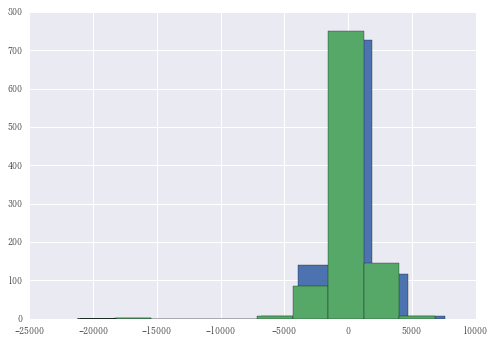

In [311]:
model.compare()

In [312]:
print(np.mean(model.error1))
print(np.mean(model.error2))

163.754931905
-29.7797052108


In [313]:
print(np.mean(np.abs(model.error1)))
print(np.mean(np.abs(model.error2)))

1167.89405709
1073.01866785


In [314]:
print(max(np.abs(model.error1)))
print(max(np.abs(model.error2)))

21206.5786028
21004.6408281


In [315]:
print(np.var(model.error1))
print(np.var(model.error2))

3690602.28497
3282789.60412


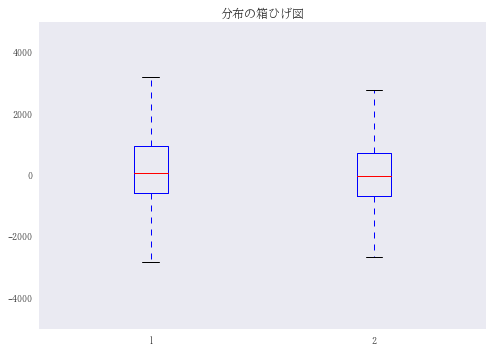

In [316]:
fig = plt.figure()
ax = fig.add_subplot(111)

errors = [model.error1, model.error2]

bp = ax.boxplot(errors)

plt.grid()
plt.ylim([-5000,5000])

plt.title('分布の箱ひげ図')

plt.show()

In [415]:
X = model.X_ex['X'].values
Y = model.X_ex['Y'].values

In [318]:
e = model.error2

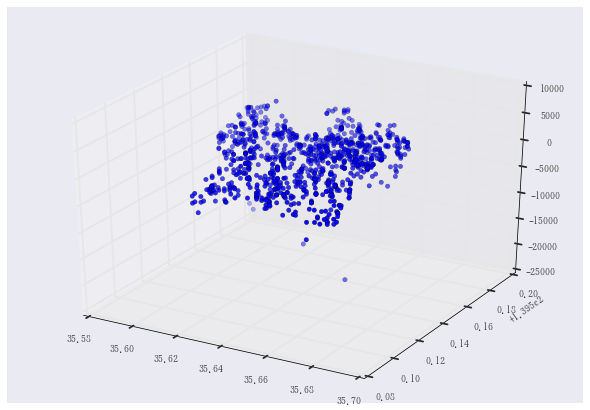

In [319]:
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

fig=plt.figure()
ax=Axes3D(fig)
 
ax.scatter3D(X, Y, e)
plt.show()

In [331]:
t

array([ 35.59299   ,  35.59450712,  35.59602424,  35.59754136,
        35.59905847,  35.60057559,  35.60209271,  35.60360983,
        35.60512695,  35.60664407,  35.60816119,  35.60967831,
        35.61119542,  35.61271254,  35.61422966,  35.61574678,
        35.6172639 ,  35.61878102,  35.62029814,  35.62181525,
        35.62333237,  35.62484949,  35.62636661,  35.62788373,
        35.62940085,  35.63091797,  35.63243508,  35.6339522 ,
        35.63546932,  35.63698644,  35.63850356,  35.64002068,
        35.6415378 ,  35.64305492,  35.64457203,  35.64608915,
        35.64760627,  35.64912339,  35.65064051,  35.65215763,
        35.65367475,  35.65519186,  35.65670898,  35.6582261 ,
        35.65974322,  35.66126034,  35.66277746,  35.66429458,
        35.66581169,  35.66732881,  35.66884593,  35.67036305,
        35.67188017,  35.67339729,  35.67491441,  35.67643153,
        35.67794864,  35.67946576,  35.68098288,  35.6825    ])

(array([ 100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.,  100.]),
 array([ 35.59299 ,  35.601941,  35.610892,  35.619843,  35.628794,
         35.637745,  35.646696,  35.655647,  35.664598,  35.673549,  35.6825  ]),
 <a list of 10 Patch objects>)

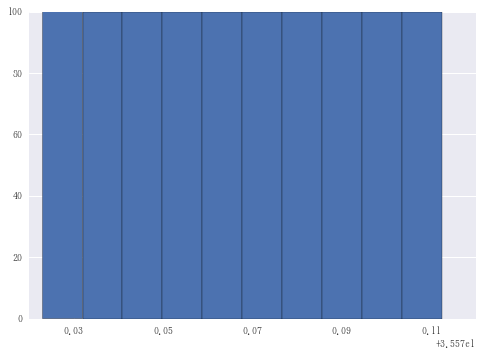

In [358]:
plt.hist(Xs)

In [339]:
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

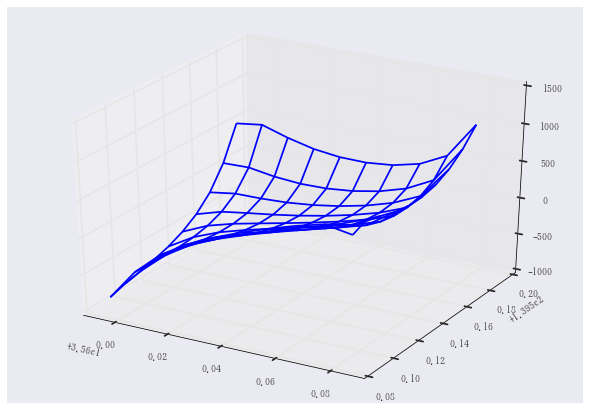

In [564]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

Xs = np.linspace(min(X),max(X),10)
Ys = np.linspace(min(Y),max(Y),10)

error = model.error1
Xgrid, Ygrid = np.meshgrid(Xs, Ys)
Z = LL(X, Y, Xs, Ys, error)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(Xgrid,Ygrid,Z) #<---ここでplot

plt.show()

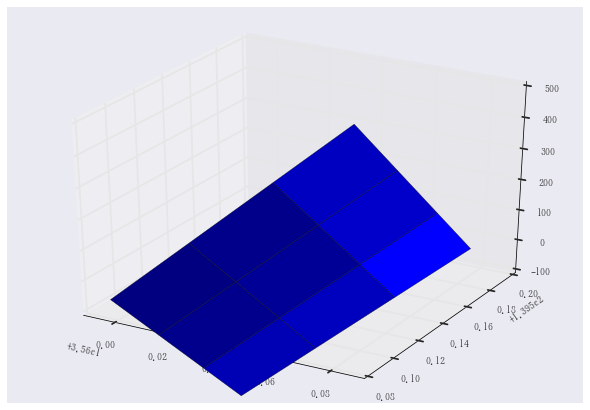

In [505]:
fig = plt.figure()
ax = Axes3D(fig)
ax.set_zlim(-100, 500)
ax.plot_surface(Xgrid,Ygrid,Z) #<---ここでplot

plt.show()

In [541]:
h = 10
(0.9375*(1-((X-1)/h)**2)**2)*(0.9375*(1-((Y-2)/h)**2)**2)

array([ 3786901.31243339,  3784625.47845582,  3777981.7633057 ,
        3758241.22292077,  3783507.56196237,  3783967.04306729,
        3777823.00996672,  3771319.94555596,  3758148.56699871,
        3780577.5522556 ,  3775695.32669684,  3779008.24766451,
        3782569.26098256,  3784973.66370602,  3766204.55437186,
        3762338.77888803,  3781761.85076149,  3771852.08386755,
        3785017.3610941 ,  3785338.51693229,  3784627.97056458,
        3776518.07809418,  3776473.4188768 ,  3769505.1587688 ,
        3789280.42521991,  3787394.138282  ,  3765459.1646375 ,
        3788411.08560455,  3762824.41040828,  3762638.78120961,
        3764436.781566  ,  3760565.07881974,  3761726.34158408,
        3759052.19393293,  3789400.06675331,  3773497.4668366 ,
        3758449.6490537 ,  3787416.11578878,  3759010.74514849,
        3785060.21514383,  3778268.73047614,  3773163.81279354,
        3792542.38195157,  3785892.21423553,  3790266.43163301,
        3780184.41451075,  3780697.33152

In [562]:
def LL(X, Y, Xs, Ys, error):   
    n = len(X)
    h = 0.1
    error = model.error2
    mean_of_error = np.zeros((len(Xs), len(Ys)))
    for i in range(len(Xs)):
        for j in range(len(Ys)):
            u1 = ((X-Xs[i])/h)**2 
            u2 = ((Y-Ys[j])/h)**2
            k = (0.9375*(1-((X-Xs[i])/h)**2)**2)*(0.9375*(1-((Y-Ys[j])/h)**2)**2)
            K = np.diag(k)
            indep = np.matrix(np.array([np.ones(n), X - Xs[i], Y-Ys[j]]).T)
            dep = np.matrix(np.array([error]).T)
            gls_model = sm.GLS(dep, indep, sigma=K)
            gls_results = gls_model.fit()
            mean_of_error[i, j] = gls_results.params[0]
    return mean_of_error

In [558]:
h = 200
u1 = ((X-30)/h)**2 

In [559]:
u1

array([ 0.00080218,  0.00079844,  0.00079512,  0.00078458,  0.00080182,
        0.00079814,  0.00079598,  0.0007913 ,  0.00078429,  0.00079676,
        0.00079371,  0.00079666,  0.00080218,  0.00079895,  0.00079134,
        0.00078946,  0.00080111,  0.00079443,  0.00079821,  0.00079887,
        0.00080112,  0.0007983 ,  0.0007985 ,  0.00079139,  0.00080236,
        0.00080183,  0.00078979,  0.00080199,  0.00078838,  0.0007882 ,
        0.00078828,  0.0007837 ,  0.00078426,  0.0007843 ,  0.00080062,
        0.00079543,  0.00078473,  0.00080416,  0.00078265,  0.00080195,
        0.000794  ,  0.00079341,  0.00080369,  0.00080056,  0.00080547,
        0.00079593,  0.00079604,  0.00079856,  0.00080236,  0.00079822,
        0.00079466,  0.00079398,  0.0008001 ,  0.00079509,  0.00080013,
        0.00079466,  0.00079393,  0.00080254,  0.00079524,  0.00079561,
        0.00078289,  0.00080139,  0.00079902,  0.00080535,  0.00079256,
        0.0007989 ,  0.00078982,  0.00080073,  0.00079549,  0.00

In [557]:
u1[u1 < 0] = 0

In [467]:
for x in range(lXs[:2]):
    print(x)

KeyboardInterrupt: 

In [499]:
mean_of_error

array([[ -78.58764766,  -77.88149257,  -77.17533748, ...,  625.44897607,
         626.15513116,  626.86128625],
       [ -79.21571684,  -78.50956175,  -77.80340666, ...,  624.8209069 ,
         625.52706199,  626.23321708],
       [ -79.84378601,  -79.13763092,  -78.43147583, ...,  624.19283773,
         624.89899281,  625.6051479 ],
       ..., 
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ]])

38

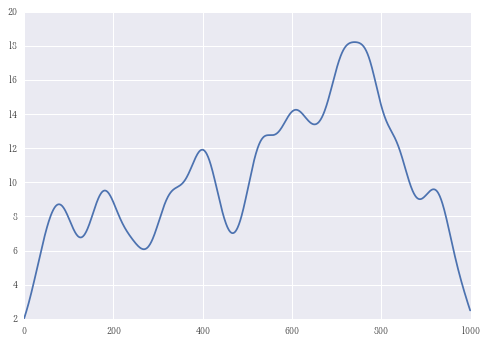

In [367]:
plt.plot(gaussian_kde(Y, 0.1)(Ys))

In [ ]:


N = 5

means = np.random.randn(N,2) * 10 + np.array([100, 200])
stdev = np.random.randn(N,2) * 10 + 30
count = np.int64(np.int64(np.random.randn(N,2) * 10000 + 50000))

a = [
    np.hstack([
        np.random.randn(count[i,j]) * stdev[i,j] + means[i,j]
        for j in range(2)])
    for i in range(N)]

In [337]:
for x in Xs:
    for y in Ys:
        

array([ 139.58772   ,  139.5893561 ,  139.5909922 ,  139.59262831,
        139.59426441,  139.59590051,  139.59753661,  139.59917271,
        139.60080881,  139.60244492,  139.60408102,  139.60571712,
        139.60735322,  139.60898932,  139.61062542,  139.61226153,
        139.61389763,  139.61553373,  139.61716983,  139.61880593,
        139.62044203,  139.62207814,  139.62371424,  139.62535034,
        139.62698644,  139.62862254,  139.63025864,  139.63189475,
        139.63353085,  139.63516695,  139.63680305,  139.63843915,
        139.64007525,  139.64171136,  139.64334746,  139.64498356,
        139.64661966,  139.64825576,  139.64989186,  139.65152797,
        139.65316407,  139.65480017,  139.65643627,  139.65807237,
        139.65970847,  139.66134458,  139.66298068,  139.66461678,
        139.66625288,  139.66788898,  139.66952508,  139.67116119,
        139.67279729,  139.67443339,  139.67606949,  139.67770559,
        139.67934169,  139.6809778 ,  139.6826139 ,  139.68425

In [249]:
def loclinearc(points,x,y,h):
    n = len(points[,1])
    const = matrix(1, nrow=length(x), ncol=1)
    bhat = matrix(0, nrow=3, ncol=n)
    b1 = matrix(0, n, n)
    predict = matrix(0, n, 1)

    for (j in 1:n) {

    for (i in 1:n) {
      a <- -.5*sign( abs( (points[i, 1]*const - x[,1])/h ) -1 ) + .5	
      #get the right data points, (K(x) ~=0)
      b <- -.5*sign( abs( (points[j, 2]*const - x[,2])/h ) -1 ) + .5

      x1andy <- nonzmat(cbind((x[,1]*a*b), (y*a*b)))
      x2andy <- nonzmat(cbind((x[,2]*a*b), (y*a*b)))
      ztheta1 <- x1andy[,1]
      ztheta2 <- x2andy[,1]
      yuse <- x1andy[,2]
      q1 <- (ztheta1 - points[i,1]);
      q2 <- (ztheta2 - points[j,2]);
      nt1 <- ( (ztheta1- points[i,1])/h )
      nt2 <- ( (ztheta2- points[j,2])/h )
      #q2 = ((ztheta - points(i,1)).^2)/2;
      weights <- diag(c((15/16)%*%( 1-(nt1^2))^2*((15/16)%*%( 1-(nt2^2))^2)))
      #Biweight Kernel
      tempp3 <- cbind(matrix(1, nrow=length(ztheta1), ncol=1), q1, q2)
      bhat[,i] <- solve(t(tempp3)%*%weights%*%tempp3)%*%t(tempp3)%*%weights%*%yuse
    }
    b1[,j] <- t(bhat[1,])
    }
    return(b1)
}


array([ 35.66455,  35.65134,  35.63957,  35.60207,  35.66327,  35.65029,
        35.64262,  35.62602,  35.60105,  35.64538,  35.63457,  35.64502,
        35.66455,  35.65314,  35.62616,  35.61948,  35.66079,  35.63714,
        35.65052,  35.65285,  35.66081,  35.65083,  35.65156,  35.62632,
        35.66519,  35.66333,  35.62063,  35.66388,  35.61562,  35.61499,
        35.61528,  35.59893,  35.60094,  35.60108,  35.65905,  35.64066,
        35.6026 ,  35.67156,  35.59519,  35.66376,  35.63561,  35.63352,
        35.66988,  35.65884,  35.67615,  35.64243,  35.64283,  35.65176,
        35.66519,  35.65055,  35.63795,  35.63552,  35.65722,  35.63948,
        35.6573 ,  35.63795,  35.63536,  35.66584,  35.63999,  35.64131,
        35.59604,  35.66175,  35.65339,  35.67573,  35.63049,  35.65297,
        35.62073,  35.65945,  35.64087,  35.63558,  35.65117,  35.65121,
        35.64002,  35.65805,  35.62836,  35.62884,  35.60686,  35.6357 ,
        35.60126,  35.64529,  35.64953,  35.64086, 

In [ ]:
nonzmat(x):
    #This function computes nonzeros of a MATRIX when certain ROWS of the 
    #matrix are zero.  This function returns a matrix with the 
    #zero rows deleted

    m, k = x.shape
    xtemp = matrix(np.zeros(m, k))

    for (i in 1:m) {
    xtemp[i,] <- ifelse(x[i,] == matrix(0, nrow=1, ncol=k), 99999*matrix(1, nrow=1, ncol=k), x[i,])
    }

    xtemp <- xtemp - 99999

    if (length(which(xtemp !=0,arr.ind = T)) == 0) {
    a <- matrix(-99999, nrow=1, ncol=k)
    } else {
    a <- xtemp[which(xtemp !=0,arr.ind = T)]
    }
    a <- a + 99999
    n1 <- length(a)
    rowlen <- n1/k
    collen <- k

    out = matrix(a, nrow=rowlen, ncol=collen)
    return(out)
    }

In [265]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as mtri



#============
# First plot
#============
# Plot the surface.  The triangles in parameter space determine which x, y, z
# points are connected by an edge.
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_trisurf(X, Y, e)
ax.set_zlim(-1, 1)
plt.show()